In [1]:
import PIL
from PIL import Image
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time

In [2]:
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

--2025-01-18 14:08:30--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  88.2MB/s    in 6.2s    

2025-01-18 14:08:36 (85.4 MB/s) - ‘vgg16-00b39a1b.pth’ saved [553451520/553451520]



In [3]:
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "/kaggle/input/coco2014/train2014"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "/kaggle/input/styles/Styles/mosaic.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17
STYLE_WEIGHT = 50
TV_WEIGHT = 1e-6 
ADAM_LR = 0.001
SAVE_MODEL_PATH = "/kaggle/working/"
SAVE_IMAGE_PATH = "/kaggle/working/"
SAVE_MODEL_EVERY = 1000 # 2,000 Images with batch size 4
SEED = 35

In [4]:
# %%writefile vgg.py
# import torch
# import torch.nn as nn
# from torchvision import models, transforms
# import utils

class VGG(nn.Module):
    def __init__(self,vgg_19=True, vgg_path='None'):
        super().__init__()
        self.vgg_19 = vgg_19
        
        if self.vgg_19:
            vgg_features = models.vgg19(pretrained=False)
        else: 
            vgg_features = models.vgg16(pretrained=False)
        vgg_features.load_state_dict(torch.load(vgg_path), strict=False)
        self.features = vgg_features.features
        
        for param in self.features.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        if self.vgg_19:
            layers = {'3': 'relu1_2', '8': 'relu2_2', '17': 'relu3_4', '22': 'relu4_2', '26': 'relu4_4', '35': 'relu5_4'}
        else:
            layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
            
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                if (not self.vgg_19 and name == '22'): #or (self.vgg_19 and name == '35'):
                    break
        return features
    

In [5]:
# %%writefile transformer.py
# import torch
# import torch.nn as nn

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm='instance'):
        super().__init__()
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        
        self.norm = norm
        if norm == 'instance':
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif norm == 'batch':
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)
        
        # Difference between instance and batch normalization
        # Instance Normalization is used for style transfer because it normalizes the activations of the features in the image
        # Batch Normalization is used for training the network because it normalizes the activations of the features in the network
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv(out)
        if self.norm == 'None':
            return out
        out = self.norm_layer(out)
        return out
    
class ResidualBlock(nn.Module):
    def __init__(self, channels=128, kernel_size=3):
        super().__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out + x
    
class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=1, norm='instance'):
        super().__init__()
        padding = kernel_size // 2
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
        
        self.norm = norm
        if norm == 'instance':
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif norm == 'batch':
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)
        
    def forward(self, x):
        out = self.deconv(x)
        if self.norm == 'None':
            return out
        out = self.norm_layer(out)
        return out

class TransformerNetwork(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        
        self.ResidualBlock = nn.Sequential(
            ResidualBlock(128,3),
            ResidualBlock(128,3),
            ResidualBlock(128,3),
            ResidualBlock(128,3),
            ResidualBlock(128,3)
        )
        
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm='None')
        )
        
    def forward(self, x):
        out = self.ConvBlock(x)
        out = self.ResidualBlock(out)
        out = self.DeconvBlock(out)
        return out
    
class TransformerNetworkTanh(TransformerNetwork):
    def __init__(self, tanh_multiplier=150, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tanh = nn.Tanh()
        self.tanh_multiplier = tanh_multiplier
        
    def forward(self, x):
        out = super().forward(x)
        out = self.tanh(out) * self.tanh_multiplier
        return out

In [6]:
# %%writefile utils.py
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision import transforms, datasets
# import cv2
# import os

def gram_matrix(x):
    (b, c, h, w) = x.size()
    features = x.view(b, c, h * w)
    features_t = features.transpose(1, 2)
    # gram = features.bmm(features_t) / (c * h * w)
    gram = torch.bmm(features, features_t) / (c * h * w)
    return gram

def load_image(image_path):
    img = cv2.imread(image_path)
    return img

def show_image(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
def save_image(img, path):
    img = img.clip(0, 255)
    cv2.imwrite(path, img)
    
def image_to_tensor(image, max_size=None):
    if max_size is None:
        itot_t = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])    
    else:
        H, W, C = image.shape
        image_size = tuple([int((float(max_size) / max([H,W]))*x) for x in [H, W]])
        itot_t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])
    # Convert image to tensor
    tensor = itot_t(image)
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def tensor_to_image(tensor):
    # Add the means
    #ttoi_t = transforms.Compose([
    #    transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    #img = ttoi_t(tensor)
    img = tensor.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

def transfer_color(src, dest):
    """
    Transfer Color using YIQ colorspace. Useful in preserving colors in style transfer.
    This method assumes inputs of shape [Height, Width, Channel] in BGR Color Space
    """
    src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR).clip(0,255)  #4 Convert new image from YIQ back to BGR

def plot_loss_hist(c_loss, s_loss, total_loss, title="Loss History"):
    x = [i for i in range(len(total_loss))]
    plt.figure(figsize=[10, 6])
    plt.plot(x, c_loss, label="Content Loss")
    plt.plot(x, s_loss, label="Style Loss")
    plt.plot(x, total_loss, label="Total Loss")
    
    plt.legend()
    plt.xlabel('Every 500 iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


In [7]:
# %%writefile train.py
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# import random
# import numpy as np
# import time

# import vgg
# import transformer
# import utils

def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    transformer_network = TransformerNetwork().to(device)
    vgg = VGG(vgg_19=False, vgg_path='/kaggle/working/vgg16-00b39a1b.pth').to(device)
    
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    style_image = load_image(STYLE_IMAGE_PATH)
    style_tensor = image_to_tensor(style_image).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    B, C, H, W = style_tensor.shape
    style_features = vgg(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = gram_matrix(value)
        
    optimizer = optim.Adam(transformer_network.parameters(), lr=ADAM_LR) 
    
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0
    
    batch_count = 1
    start_time = time.time()
    
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # Free-up unneeded cuda memory
            # torch.cuda.empty_cache()

            # Zero-out Gradients
            optimizer.zero_grad()
            
            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = transformer_network(content_batch)
            content_features = vgg(content_batch.add(imagenet_neg_mean))
            generated_features = vgg(generated_batch.add(imagenet_neg_mean))
            
            # Content Loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(content_features['relu2_2'], generated_features['relu2_2'])            
            batch_content_loss_sum += content_loss
            
            # Style Loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(gram_matrix(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()
            
            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            total_loss.backward()
            optimizer.step()
            
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))
            
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(transformer_network.state_dict(), checkpoint_path)
                print("Saved transformer_network checkpoint file at {}".format(checkpoint_path))

                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = tensor_to_image(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                save_image(sample_image, sample_image_path)
                print("Saved sample tranformed image at {}".format(sample_image_path))
                
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
                
            batch_count += 1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 
    
    transformer_network.eval()
    transformer_network.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(transformer_network.state_dict(), final_path)
    print("Done saving final model")
    
    return content_loss_history, style_loss_history, total_loss_history

    

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-05ce1d0e6504>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

========Epoch 1/1========
========Iteration 1/20696========
	Content Loss:	2917066.00
	Style Loss:	201264656.00
	Total Loss:	204181728.00
Time elapsed:	0.6733052730560303 seconds
Saved transformer_network checkpoint file at /kaggle/working/checkpoint_0.pth
Saved sample tranformed image at /kaggle/working/sample0_0.png
========Iteration 1001/20696========
	Content Loss:	9000295.00
	Style Loss:	25056065.22
	Total Loss:	34056364.12
Time elapsed:	135.21139216423035 seconds
Saved transformer_network checkpoint file at /kaggle/working/checkpoint_1000.pth
Saved sample tranformed image at /kaggle/working/sample0_1000.png
========Iteration 2001/20696========
	Content Loss:	8903007.00
	Style Loss:	14611774.98
	Total Loss:	23514789.03
Time elapsed:	268.93225479125977 seconds
Saved transformer_network checkpoint file at /kaggle/working/checkpoint_2000.pth
Saved sample tranformed image at /kaggle/working/sample0_2000.png
========Iteration 3001/20696========
	Content Loss:	8561656.00
	Style Loss:	10

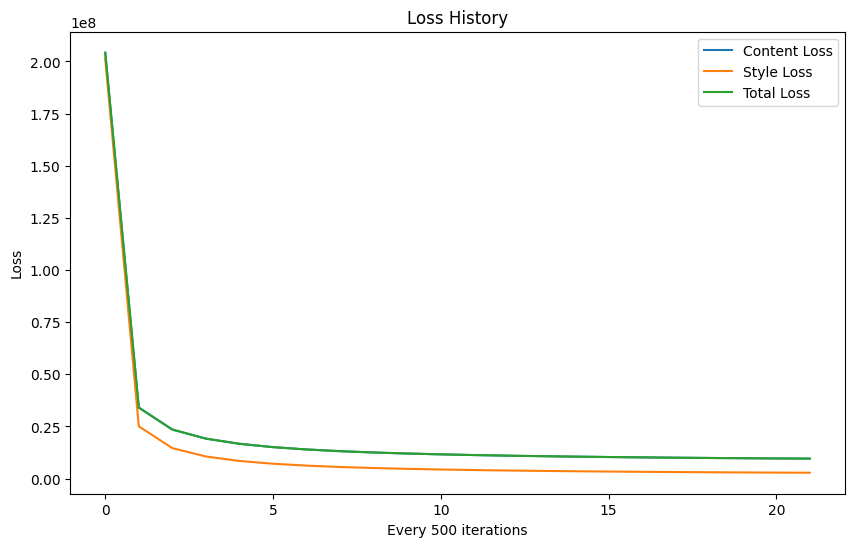

In [8]:
content_loss_history, style_loss_history, total_loss_history = train()
plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)